# Task 3

The purpose of this code is to investigate a two dimensional grid of dipoles using the ising model.

In [136]:
# Import needed libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
%matplotlib notebook

## Task 3.1

In this code the ising model is implemented with an evenly spaced lattice of dipoles, as a python object with methods for evolving the states of the dipoles.

In [188]:
class DipoleLattice():
    """A lattice of magnetic dipoles in a magnetic field which are weakly coupled with each other."""
    
    def __init__(self, J = 1.0, B = 1.0, T = 1.0, M = 51, N = 49, grid = None, prob = 0.5, m = 1.0, k_b = 1.0):
        """Initialize grid and constants
        
        Arguments:
        J -- coupling constant
        B -- external magnetic field
        T -- temperature
        M -- number of rows in the grid
        N -- number of columns in the grid
        grid -- dipole lattice
        prob -- probability for initializing the grid if None
        m -- magnetic moment
        k_b -- boltzmann constant"""
        
        # If no grid is initialized, initialize a random grid of 1's and -1's
        if grid is None: 
            grid = np.array(2*(np.random.rand(M,N) > prob) - 1, dtype = np.int8)
        
        # Set instance variables
        self.J = J
        self.B = B
        self.T = T
        self.grid = grid
        self.m = m
        self.k_b = k_b
        self.Mag = []
        
        # Initializes proportion of grid to change for partial steps
        self.prop = 0.05
        
    
    def set_J(self, J):
        """Changes the coupling constant"""
        self.J = J
    
    def set_B(self, B):
        """Changes the external magnetic field"""
        self.B = B
        
        
    def set_T(self, T):
        """Changes the temperature"""
        self.T = T
        
    def set_prop(self, prop):
        """Changes the proportion of grid to change"""
        # Ensures the proportion is valid
        assert( prop <= 1 and prop >= 0 )
        self.prop = prop
        
    def reset_Mag(self):
        """Resets magnetization array"""
        self.Mag = []
        
        
    def update_Mag(self):
        """Append the magnetization for the current grid"""
        
        self.Mag.append(np.sum(self.grid)/np.size(self.grid))
        
        return self.Mag
    
    
    def flip_partial(self, near, xx, yy):
        """Flips the states of the whole grid simultaneously
        
        Arguments:
        near -- grid of the sum of states of neighboring dipoles
        xx -- x-coordinates of dipoles to be tested
        yy -- y-coordinates of dipoles to be tested"""
        
        # Obtains a grid of changes in energy associated to a state change of each dipole in the grid
        delta_E = 2*self.B*self.m*self.grid[xx,yy]+2*self.J*self.grid[xx,yy]*near # JUSTIFY THIS POSSIBLY IN A COMMENT
    
        # Finds the probability that the dipole will flip
        probs = np.minimum(1, np.exp(-delta_E/(self.m*self.T))) 


        # Creates a grid of 1's and -1's based on the Metropolist flip probability, where a 1 corresponds
        # to flipping the associated dipole and a -1 corresponds to leaving its state unchanged
        flip_grid = probs > np.random.rand(len(probs))
        flip_grid = 2*flip_grid-1

        # Flips the appropriate dipoles
        self.grid[xx, yy] = self.grid[xx,yy]*(-flip_grid)
        

    def ising_stepper_partial(self):
        """Iterates a portion of the grid based on the probability specified at initialization"""
        
        # Obtains an integer number of grids to test
        nx, ny = self.grid.shape
        prop_grid = int(nx*ny*self.prop)
        
        # Obtains random indexes of dipoles to be tested
        x_range = np.random.randint(nx, size = prop_grid)
        y_range = np.random.randint(ny, size = prop_grid)
        
        # Sums the states of the neighbors of each dipole we are testing
        sum_near = self.grid[(x_range+1)%nx, y_range]+self.grid[(x_range-1)%nx, y_range] \
                + self.grid[x_range, (y_range+1)%ny]+self.grid[x_range, (y_range-1)%ny]
        
        # Performs a flip test using the Metropolis algorithm
        self.flip_partial(sum_near, x_range, y_range)
        
        
    def thermalize(self, nsteps = 200, plot = False, update_Mag = False):
        """Thermalizes the lattice of dipoles by repeatedly applying the stepper.
        If plot is true animates the thermalization, and if update_Mag is true
        the magnetization of the grid is recorded."""
        for i in range(nsteps):
            # Evolves the dipole
            self.ising_stepper_partial()
            if plot:
                # Plots the current lattice with the external magnetic field
                self.ax.set(title = "Dipole Lattice, $B = {}$".format(self.B))
                self._animate_step(nsteps = 1)
            
            if update_Mag:
                # Updates the magnetization of the lattice
                self.update_Mag()
        return self.Mag
    
    def plot_grid(self):
        """Plots the current lattice of dipoles"""
        
        fig, ax = plt.subplots()
        ax.set(title = "Dipole Lattice, $B = {}$".format(self.B))
        img = ax.imshow(self.grid, interpolation = 'nearest')
        fig.show()
        plt.colorbar(img)
        return (img,)
    
    
    # Animation functions inspired by Dr. Jackel's Game of Life code
    def _animate_init(self):
        """Initializes grid for animation and adds a colorbar for specifying up and down spins"""
        self.fig, self.ax = plt.subplots()
        self.plt = self.ax.imshow(self.grid, interpolation='nearest')  
        self.fig.show()
        plt.colorbar(self.plt)
        return (self.plt,)
    
    def _animate_step(self, nsteps = 1):
        """Animates a certain number of steps"""
        for i in range(nsteps):
            # Performs a step for the model and plots the resulting grid
            self.ising_stepper_partial()
            self.plt.set_data( self.grid )
        
            self.fig.canvas.draw() ; self.fig.canvas.flush_events() #update plot window
            
        return (self.plt,)

<IPython.core.display.Javascript object>


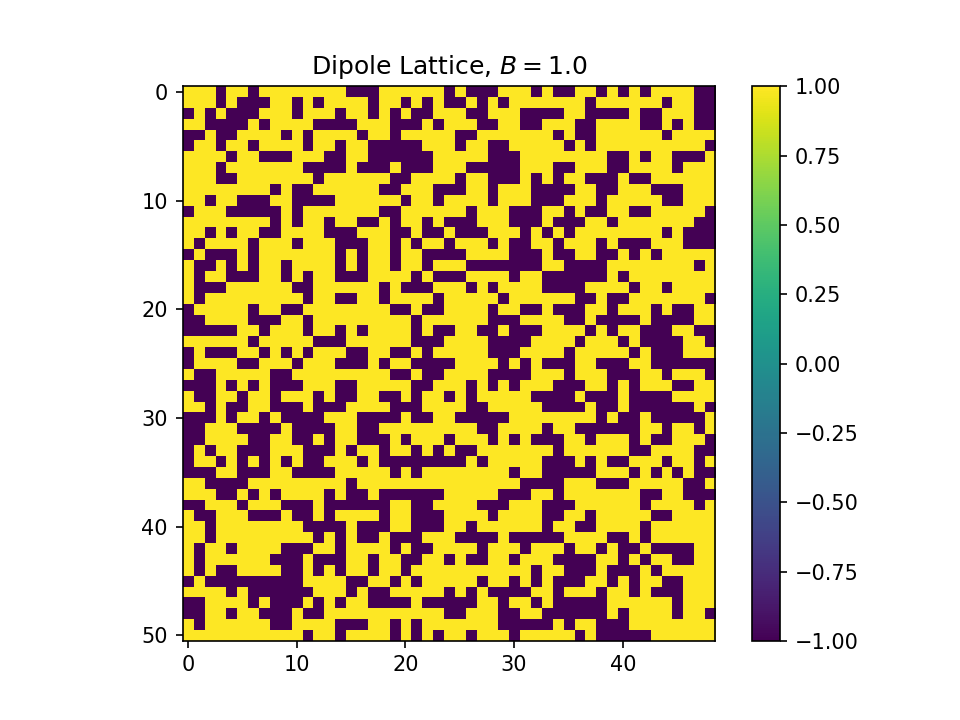

[]

In [190]:
# Tests a dipole lattice with thermalization and then plotting of the randomization
test_lattice = DipoleLattice(T = 10.0)
test_lattice.thermalize()
test_lattice._animate_init()
test_lattice.thermalize(nsteps = 20, plot = True)

In the above plot we see a sample dipole lattice after 220 runs, with a temperature of 10.0, an external magnetic field of 1.0, a coupling constant of 1.0, a magnetic moment of 1.0, and a scaled Boltzmann constant of 1.0 for simplification.

## Task 3.2

The purpose of this code is to test the ising model implementation in the last step for certain external magnetic fields, and for a fixed ratio of the coupling constant, J, to the temperature and boltzmann constant.

<IPython.core.display.Javascript object>


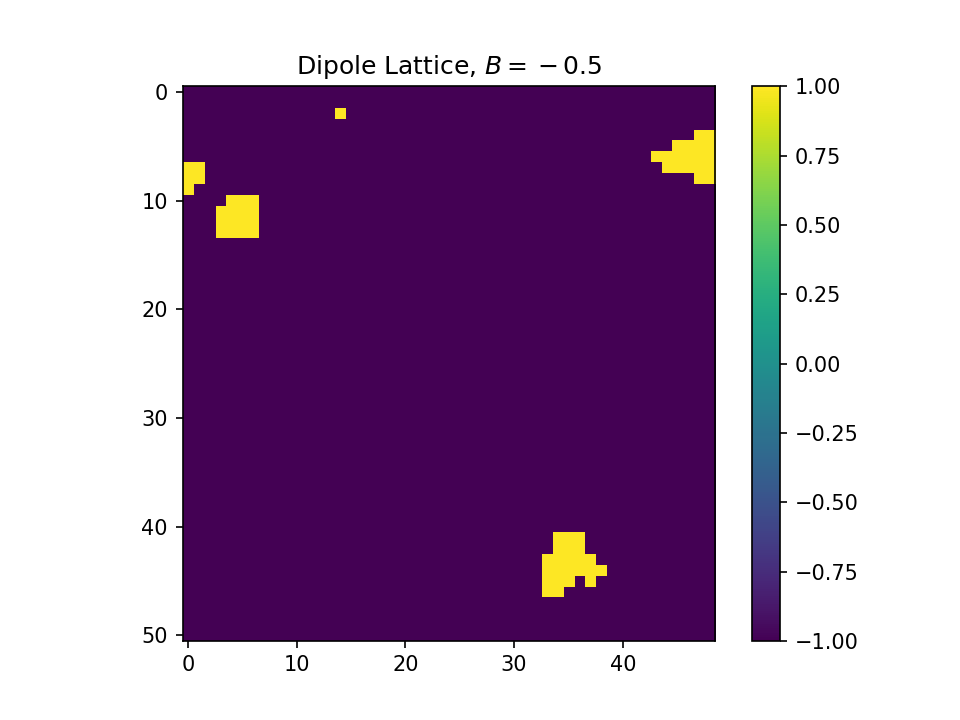

<IPython.core.display.Javascript object>


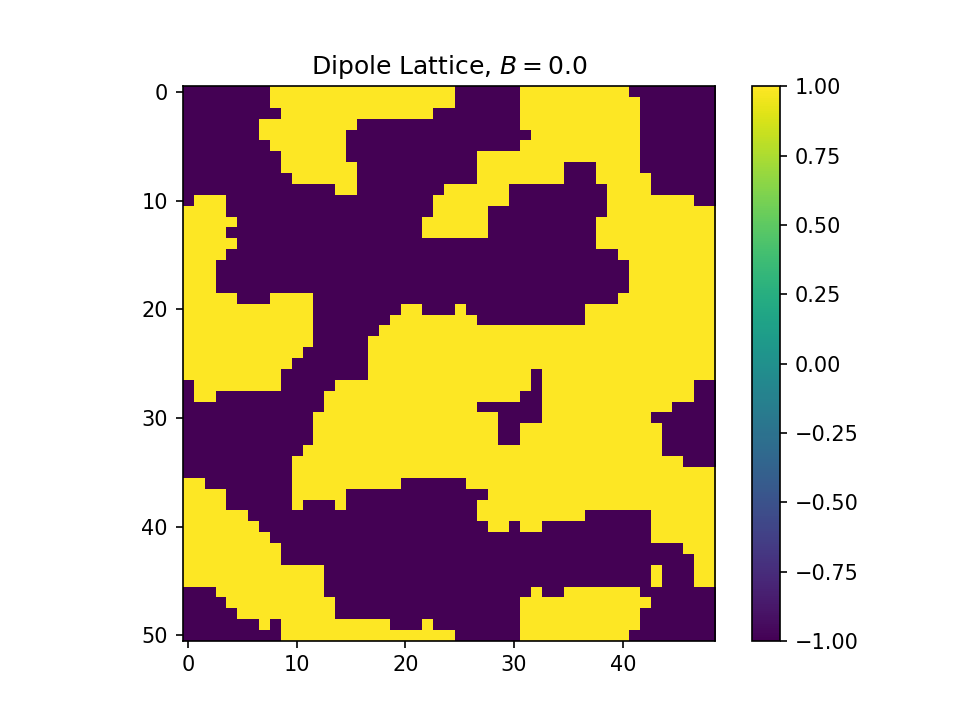

<IPython.core.display.Javascript object>


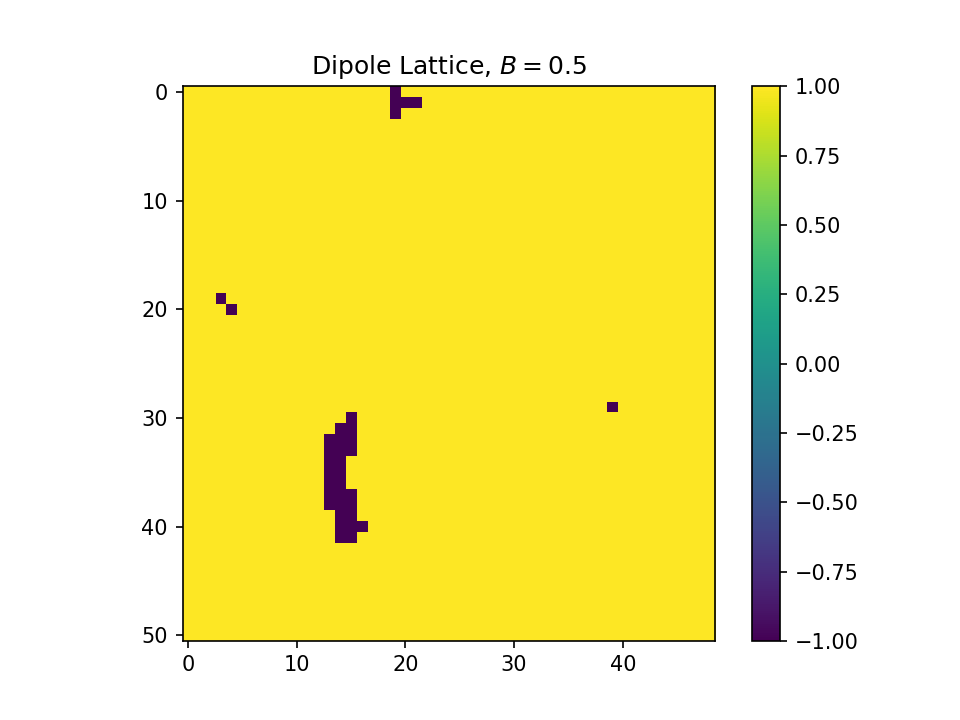

In [149]:
# Initialize array of test magnetic fields
B_array = [-0.5, 0.0, 0.5]


for B in B_array:
    # Create dipole lattice in an external magnetic field B
    mag_lattice = DipoleLattice(T = 1.5, J = 1.5, B = B)
    
    # Thermalize the lattice then animate 50 steps of the evolution
    mag_lattice.thermalize(nsteps = 200)
    mag_lattice._animate_init()
    mag_lattice.thermalize(nsteps = 50, plot = True)

Hence, we see that for a negative external magnetic field the dipoles align with spin down for the most part, while for a positive external magnetic field the dipoles align with spin up. Further, when no external magnetic field is present we see a variety of magnetic domains caused by coupling of neighboring dipoles as well as the randomness caused by the temperature of the system.

## Task 3.3

The purpose of this code is to plot and analyze the average magnetization of the lattice of dipoles versus the ratio of the coupling constant to the temperature, $J/k_BT$, when the external magnetic field is zero.

In [185]:
def plot_Mag(B, ratio_range, k_b = 1.0, M = 51, N = 49, iterations = 20, num_lattices = 3):
    """Plots the average magnetization for various values of the ratio J/k_BT
    
    Arguments:
    B -- external magnetic field
    ratio_range -- list of J/k_bT values used
    k_b -- scaled Stefan-Boltzmann constant
    M -- the number of rows in the dipole lattice
    N -- the number of columns in the dipole lattice
    iterations -- number of iterations in each run
    num_lattices -- number of dipole lattices to be tested
    """
    
    # Initializes the range of coupling constants 
    J_range = ratio_range*1.0*k_b
    
    # Creates a figure with subplots for storing the magnetization plot in the top row,
    # and the final states of the dipole lattices in the bottom row
    fig = plt.figure(figsize=(8, 6))
    grid = plt.GridSpec(2, num_lattices, hspace=0.2, wspace=0.6)
    mag_ax = fig.add_subplot(grid[0, :])
    mag_ax.set(xlabel = "Coupling per unit temperature, $J/Tk_b$", ylabel = "Magnetization, $m$",
               title = "Magnetization versus $J/Tk_b$")
    lattices = [fig.add_subplot(grid[1, i]) for i in range(num_lattices)]
    
    
    # Calculates and plots the average magnetization of dipole lattices with the same initial conditions
    for i in range(num_lattices):
        
        # Initialize a dipole lattice for the current cell of the plot
        magno_lattice = DipoleLattice(B = B, T = 1.0, J = 1.0, k_b = k_b, M = M, N = N)
        # Initialize array of average magnetizations
        M_avgs = np.zeros(len(J_range))
        
        for j in range(len(J_range)):
            # Sets the coupling constant and thermalizes the lattice before updating
            # the magnetization over a certain number of steps
            magno_lattice.set_J(J_range[j])
            magno_lattice.thermalize(nsteps = 200)
            magno_lattice.thermalize(nsteps = iterations, update_Mag = True)
            
            # Calculates the average magnetization for the current coupling constant and resets the collection of magnetizations
            M_avgs[j] = np.mean(magno_lattice.Mag)
            magno_lattice.reset_Mag()
        
        # Plots the grid for the current dipole lattice and adds the magnetization plot to the top figure
        lattices[i].imshow(magno_lattice.grid, interpolation='nearest')
        lattices[i].set(title = f"Dipole Lattice {i+1}")
        mag_ax.plot(ratio_range, M_avgs, label = f"Run #{i+1}")
    
    # Sets the magnetization plot limits and adds a legend
    mag_ax.set(xlim = (ratio_range[0], ratio_range[-1]), ylim = (-1.0, 1.0))
    mag_ax.legend()

<IPython.core.display.Javascript object>


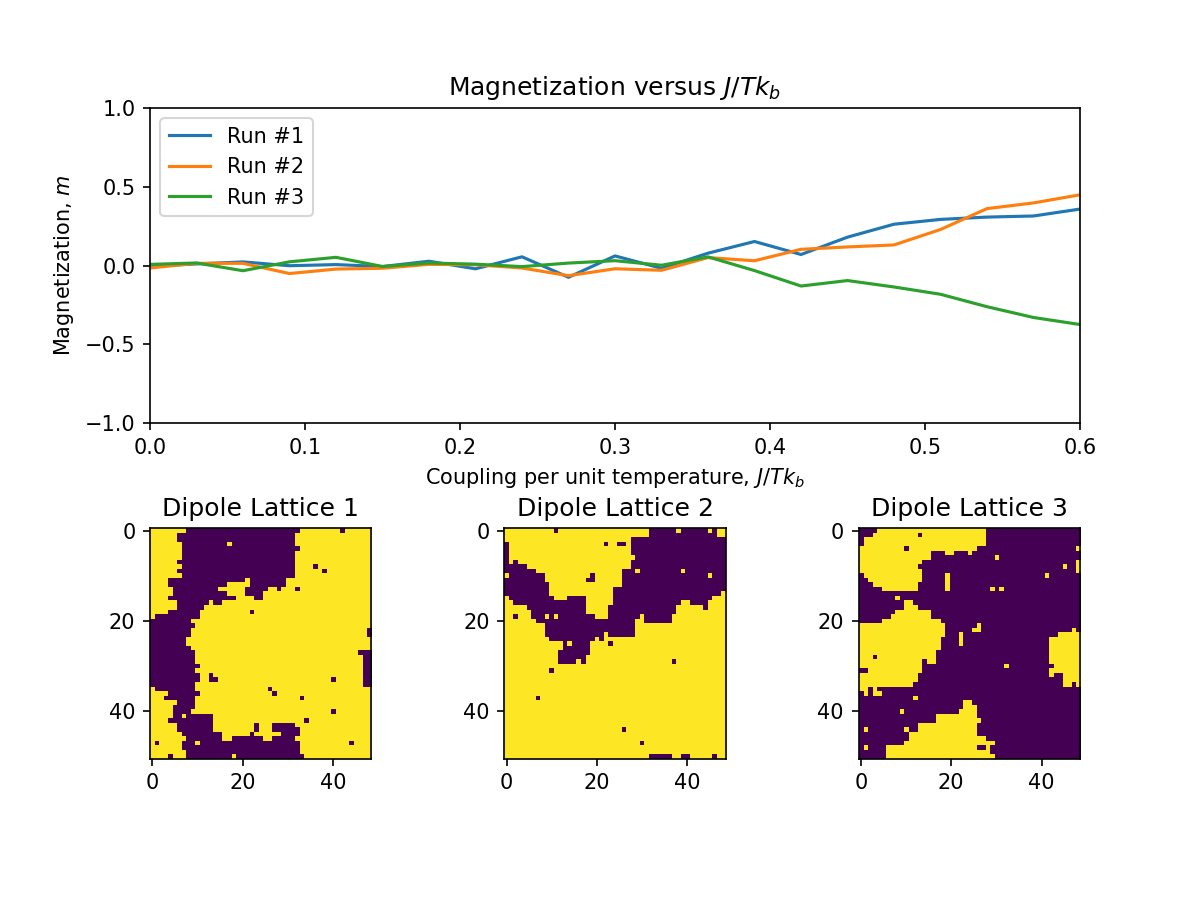

In [191]:
# Plots the magnetization grid for a specified range of coupling constant to temperature ratios, 
# with a zero external magnetic field
ratio_range = np.linspace(0.0, 0.6, 21)

plot_Mag(0.0, ratio_range)

As we can see in the magnetization plot, as the coupling constant is increased magnetic domains start to form and increase in size, causing the overall absolute value of the magnetization of the grid to increase.

## Task 3.4

The purpose of this code is to use the ising model to plot a hysterisis curve for a dipole lattice given a certain maximum external magnetic field.

In [16]:
def increasing_B(lattice, B_max, Avg_Mags, Magnetic_fields, iterations = 20, dB = 0.1):
    """Increments the external magnetic field up to some maximum value, recording the average 
    magnetization of the lattice at each step"""
    
    while lattice.B < B_max:
        # Increments the external magnetic field strength
        lattice.set_B(lattice.B + dB)
        Magnetic_fields.append(lattice.B)
        Mag = lattice.thermalize(nsteps = iterations, update_Mag = True)
        
        # Calculates the average magnetization for the current magnetic field and resets the collection of magnetizations
        Avg_Mags.append(np.sum(Mag)/len(Mag))
        lattice.reset_Mag()
    
    return Avg_Mags, Magnetic_fields

In [17]:
def decreasing_B(lattice, B_max, Avg_Mags, Magnetic_fields, iterations = 20, dB = 0.1):
    """Increments the external magnetic field up to some maximum value, recording the average 
    magnetization of the lattice at each step"""
    
    while lattice.B > -B_max:
        # Increments the external magnetic field strength
        lattice.set_B(lattice.B - dB)
        Magnetic_fields.append(lattice.B)
        Mag = lattice.thermalize(nsteps = iterations, update_Mag = True)
        
        # Calculates the average magnetization for the current magnetic field and resets the collection of magnetizations
        Avg_Mags.append(np.sum(Mag)/len(Mag))
        lattice.reset_Mag()
    
    return Avg_Mags, Magnetic_fields

In [56]:
def plot_Hysterisis(lattice, B_max, iterations = 20, dB = 0.1):
    """Plots a hysterisis curve for the grid of magnetic dipoles
    
    Arguments:
    lattice -- grid of dipoles to evolve in time
    B_max -- maximum magnetic field strength to range between
    iterations -- number of iterations in each run
    """
    
    # Initialize array of average magnetizations and magnetic fields
    Avg_Mags = []
    Magnetic_fields = []
    
    # Initially increases the magnetic field to max
    Avg_Mags, Magnetic_fields = increasing_B(lattice, B_max, Avg_Mags, Magnetic_fields, \
                                             iterations = iterations, dB = dB)
    
    # Decreases the magnetic field to a min, then raises it back up to a max
    Avg_Mags, Magnetic_fields = decreasing_B(lattice, B_max, Avg_Mags, Magnetic_fields, \
                                             iterations = iterations, dB = dB)
    Avg_Mags, Magnetic_fields = increasing_B(lattice, B_max, Avg_Mags, Magnetic_fields, \
                                             iterations = iterations, dB = dB)
    
    
    # Plots the hysterisis curve
    ax = plt.subplot(xlabel = "External Field Strength, $B$", ylabel = "Magnetization, $m$",
                      title = "Magnetization versus External Field Strength")
    ax.plot(Magnetic_fields, Avg_Mags)

<IPython.core.display.Javascript object>


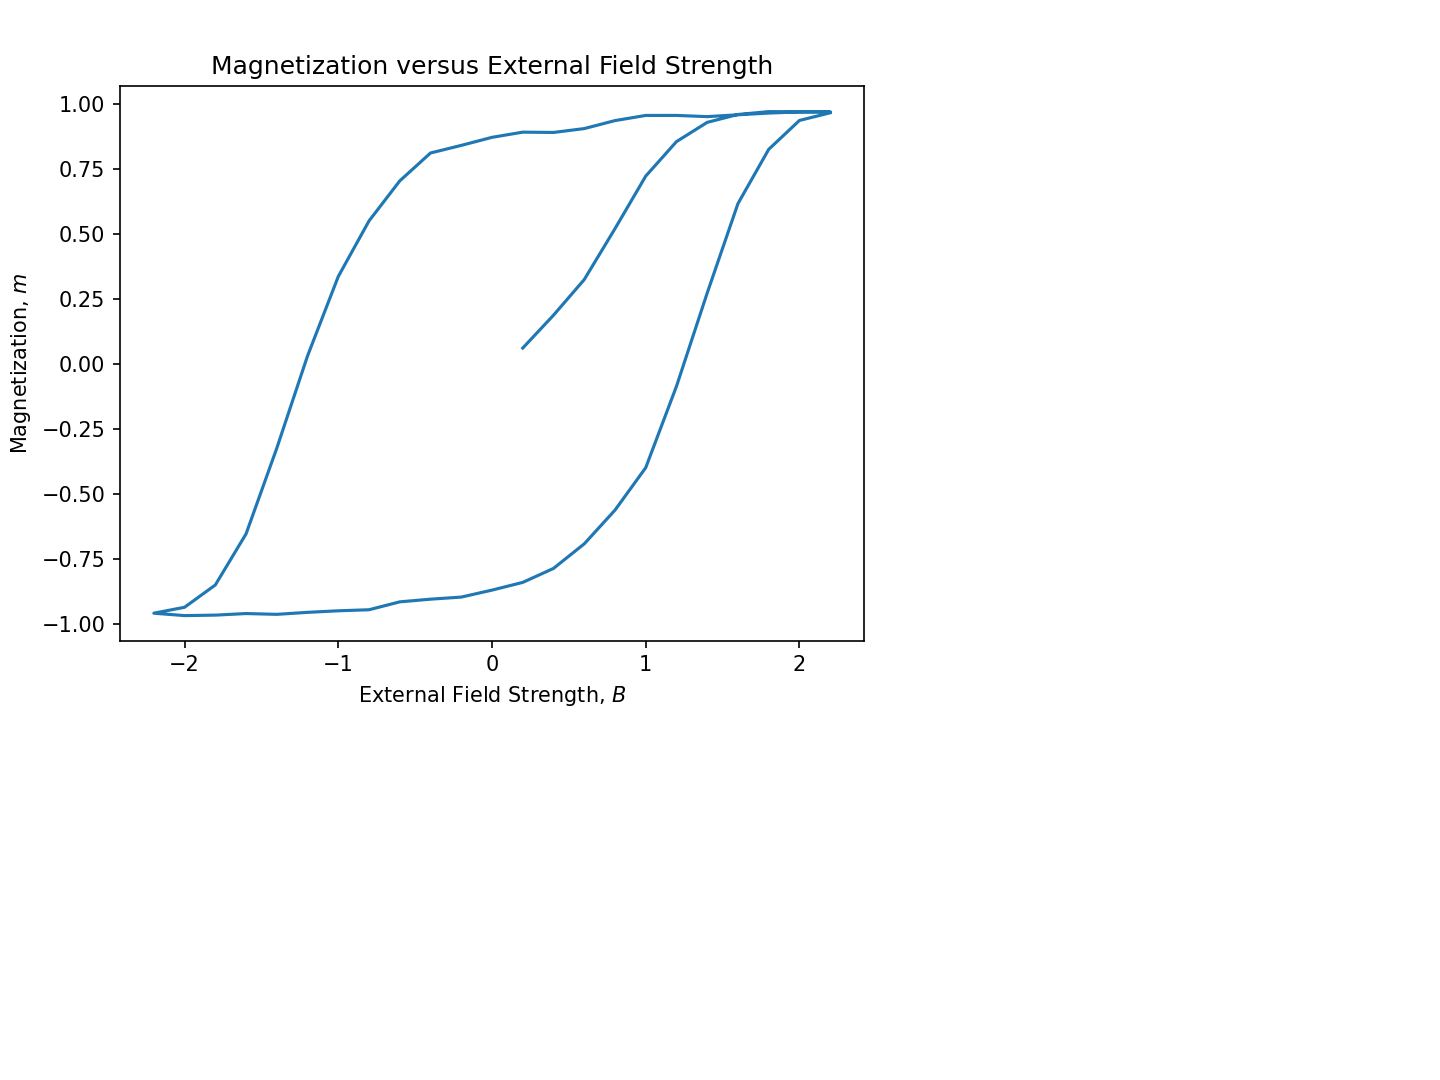

In [57]:
hysterisis_lattice = DipoleLattice(B = 0.0, J = 2.0, T = 4.5)

plot_Hysterisis(hysterisis_lattice, 2.0, iterations = 50, dB = 0.2)

Evidently, in the above plot we can see a clear hysterisis curve for dipole lattice, where the magnetization is initially increased from zero, but then as it is reduced the the magnetization of the lattice does not change greatly until the external magnetic field is negative due to the coupling of neighboring dipoles. A similar behaviour is seen when the magnetic field is increased from the negative maximum back to the positive one, with only a marginal change in the magnetization of the lattice being observed until the external magnetic field changes from negative to positive.

## Task 3.5

In this code we investigate the steady state of the dipole lattice with a negative coupling constant.

<IPython.core.display.Javascript object>


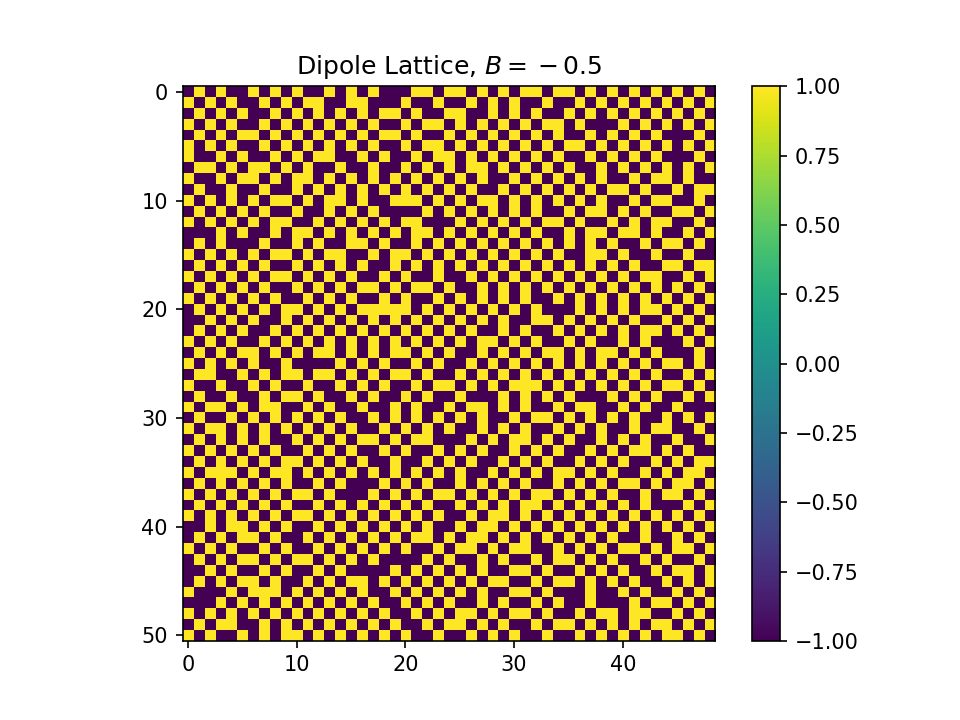

<IPython.core.display.Javascript object>


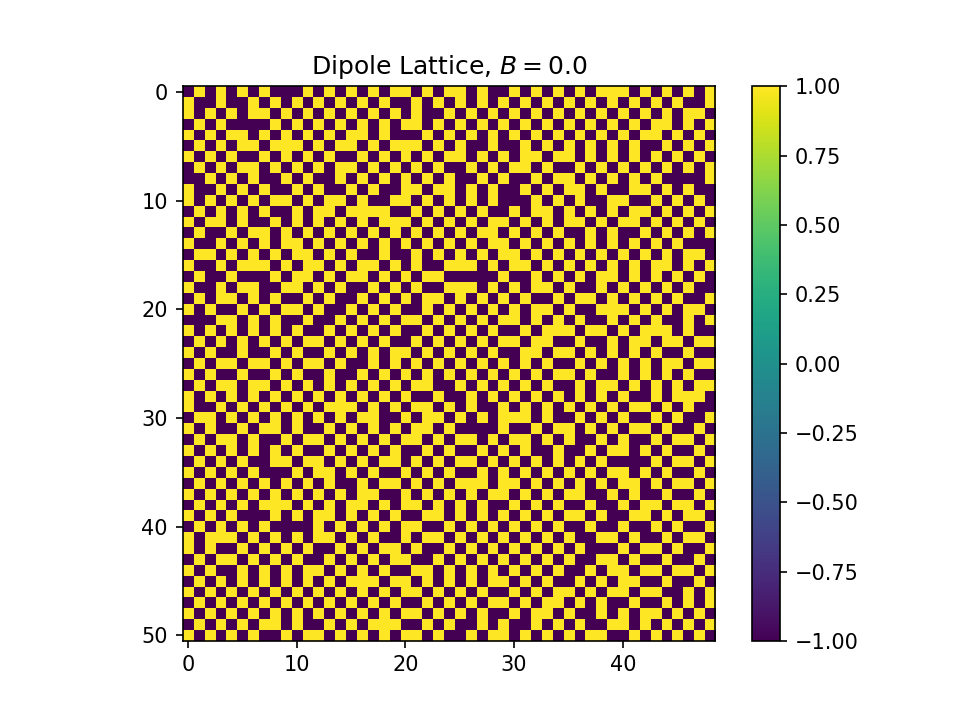

<IPython.core.display.Javascript object>


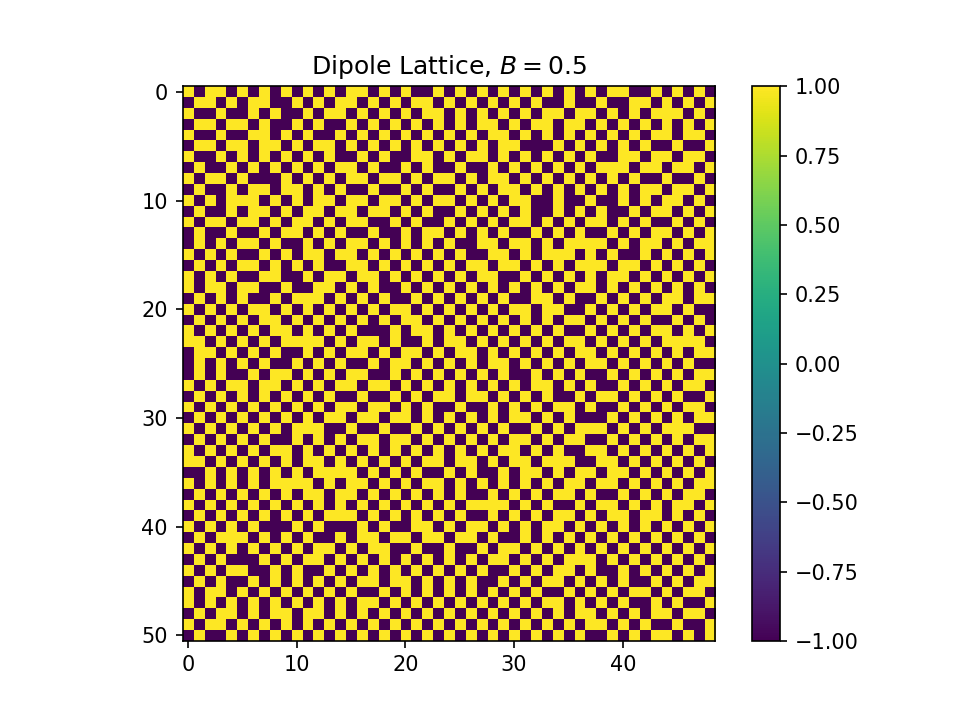

In [156]:
# Animates the evolution of a dipole lattice with negative coupling for a range of external magnetic fields
B_range = [-0.5, 0.0, 0.5]

for B in B_range:
    coupling_lattice = DipoleLattice(T = 1.0, J = -1.0, B = B)
    coupling_lattice._animate_init()
    coupling_lattice.thermalize(nsteps = 50, plot = True)

As we can see in the above tests, in each case the dipole lattice quickly begins to form a type of checkerboard pattern as neighboring dipoles attempt to make the spin of their neighbors opposite to their own.

## Task 3.6

